# 🏆 공정한 RD 모델 백본 네트워크 비교

ResNet50 vs ConvNeXt 백본 네트워크의 공정한 성능 비교를 위한 테스트 노트북

## 공정한 비교 조건
- **동일한 평가 방식**: ResNet RD_Tester.ipynb 방식 사용
- **동일한 anomaly map 계산**: 마지막 스케일만 사용
- **동일한 similarity 계산**: Cosine Similarity
- **동일한 후처리**: Gaussian filter (sigma=4)
- **동일한 sample score**: Max pooling
- **동일한 데이터셋**: MVTec bottle

## 1. 환경 설정 및 라이브러리 로드

In [1]:
import os
import json
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# 데이터 및 모델 import
from dataset import get_data_transforms, RD_Dataset
from RD_ConvNeXt_Model import rd_convnext_model
from resnet import resnet50
from de_resnet import de_resnet50

from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")
if cuda_available:
    print(f"CUDA device: {torch.cuda.get_device_name(0)} | count: {torch.cuda.device_count()}")

CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU | count: 1


## 2. 실험 설정값 및 경로 구성

In [2]:
from types import SimpleNamespace

def set_seed(seed: int) -> None:
    """재현성을 위해 모든 시드를 고정합니다."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

config = SimpleNamespace(
    class_name='bottle',
    image_size=256,
    center_crop=256,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    device='cuda' if cuda_available else 'cpu',
    convnext_checkpoint=Path('checkpoints') / 'convnext_pure_bottle.pth',
    resnet50_checkpoint=Path('checkpoints') / 'res50_bottle.pth',
    test_data_root=Path('data') / 'bottle',
    results_dir=Path('results') / 'fair_comparison',
    seed=42,
    gaussian_sigma=4,
    use_half=False,
    use_bfloat16=False,
)

set_seed(config.seed)
config.results_dir.mkdir(parents=True, exist_ok=True)

print("Configuration:")
for key, value in vars(config).items():
    print(f"  {key}: {value}")

Configuration:
  class_name: bottle
  image_size: 256
  center_crop: 256
  batch_size: 1
  num_workers: 4
  pin_memory: True
  device: cuda
  convnext_checkpoint: checkpoints\convnext_pure_bottle.pth
  resnet50_checkpoint: checkpoints\res50_bottle.pth
  test_data_root: data\bottle
  results_dir: results\fair_comparison
  seed: 42
  gaussian_sigma: 4
  use_half: False
  use_bfloat16: False


## 3. 테스트 데이터셋 준비

In [3]:
# 테스트 데이터셋 준비
test_root = Path(config.test_data_root)
if not test_root.exists():
    raise FileNotFoundError(f"Test data directory not found: {test_root}")

transform = get_data_transforms(config.image_size, config.center_crop)
test_dataset = RD_Dataset(root=test_root, transform=transform, phase='test')
print(f"Test samples: {len(test_dataset)}")

# 클래스 분포 확인
defect_types, counts = np.unique(test_dataset.types, return_counts=True)
print("Class distribution (test):")
for cls, cnt in zip(defect_types, counts):
    print(f"  {cls:>12}: {cnt}")

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory,
    drop_last=False,
)

print(f"DataLoader batches: {len(test_loader)} | batch_size={config.batch_size}")

Test samples: 83
Class distribution (test):
  broken_large: 20
  broken_small: 22
  contamination: 21
          good: 20
DataLoader batches: 83 | batch_size=1


## 4. 공통 평가 함수 정의

In [4]:
def normalize_scores(scores: np.ndarray) -> np.ndarray:
    """스코어를 0~1 범위로 정규화합니다."""
    if scores.size == 0:
        return scores
    min_v = scores.min()
    max_v = scores.max()
    if math.isclose(max_v, min_v):
        return np.zeros_like(scores)
    return (scores - min_v) / (max_v - min_v)


def calculate_metrics(scores, labels, model_name):
    """성능 지표를 계산합니다."""
    labels_array = np.array(labels, dtype=np.int64)
    scores_array = np.array(scores, dtype=np.float32)
    norm_scores = normalize_scores(scores_array)
    
    # ROC-AUC 계산
    try:
        if len(np.unique(labels_array)) < 2:
            roc_auc = float('nan')
        else:
            roc_auc = roc_auc_score(labels_array, norm_scores)
    except ValueError:
        roc_auc = float('nan')
    
    # 최적 threshold 찾기
    thresholds = np.linspace(0.0, 1.0, 101)
    best_f1 = 0
    best_metrics = {}
    
    for thr in thresholds:
        preds = (norm_scores >= thr).astype(int)
        
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels_array, preds, average='binary', zero_division=0
        )
        accuracy = accuracy_score(labels_array, preds)
        
        if f1 > best_f1:
            best_f1 = f1
            best_metrics = {
                'model': model_name,
                'threshold': thr,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc_auc,
            }
    
    return best_metrics

print("✅ 공통 평가 함수 정의 완료")

✅ 공통 평가 함수 정의 완료


## 5. ResNet50 RD 모델 평가 (표준 방식)

In [5]:
def evaluate_resnet_rd_standard(checkpoint_path, test_loader, config):
    """ResNet RD 모델의 표준 평가 방식 (RD_Tester.ipynb와 동일)"""
    device = config.device
    
    # 모델 로드
    encoder, bn = resnet50(pretrained=True)
    encoder = encoder.to(device)
    bn = bn.to(device)
    encoder.eval()
    
    decoder = de_resnet50(pretrained=False)
    decoder = decoder.to(device)
    
    # 체크포인트 로드
    ckp = torch.load(checkpoint_path, map_location=device)
    # memory 키 제거 (중요!)
    for k, v in list(ckp['bn'].items()):
        if 'memory' in k:
            ckp['bn'].pop(k)
    
    decoder.load_state_dict(ckp['decoder'])
    bn.load_state_dict(ckp['bn'])
    bn.eval()
    decoder.eval()
    
    all_sample_scores = []
    all_labels = []
    all_types = []
    
    print("🔄 ResNet50 RD 표준 평가...")
    progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), desc="ResNet50 Standard")
    
    with torch.no_grad():
        for batch_idx, (images, labels, defect_types) in progress_bar:
            images = images.to(device)
            
            # RD forward (RD_Tester 방식)
            inputs = encoder(images)
            outputs = decoder(bn(inputs))
            
            # Anomaly map 계산 (마지막 스케일만)
            fs = inputs[-1]  # student feature
            ft = outputs[-1]  # teacher feature
            
            a_map = 1 - F.cosine_similarity(fs, ft)
            a_map = torch.unsqueeze(a_map, dim=1)
            a_map = F.interpolate(a_map, size=config.center_crop, mode='bilinear', align_corners=True)
            anomaly_map = a_map[0, 0, :, :].to('cpu').detach().numpy()
            
            # Gaussian filter
            anomaly_map = gaussian_filter(anomaly_map, sigma=config.gaussian_sigma)
            
            # Sample score
            sample_score = float(np.max(anomaly_map))
            all_sample_scores.append(sample_score)
            
            # Labels
            labels_np = labels.detach().cpu().numpy().astype(int)
            all_labels.extend(labels_np.tolist())
            all_types.extend(list(defect_types))
            
            progress_bar.set_postfix({'max_score': f"{sample_score:.4f}"})
    
    return all_sample_scores, all_labels, all_types


# ResNet50 평가 실행
print("=" * 60)
print("[1/2] ResNet50 RD 표준 평가 시작")
print("=" * 60)

resnet_scores, resnet_labels, resnet_types = evaluate_resnet_rd_standard(
    config.resnet50_checkpoint, test_loader, config
)
resnet_metrics = calculate_metrics(resnet_scores, resnet_labels, "ResNet50 RD")

print(f"\n✅ ResNet50 Results:")
for key, value in resnet_metrics.items():
    if isinstance(value, float) and key != 'threshold':
        print(f"  {key.upper():12}: {value:.4f}")
    elif key == 'threshold':
        print(f"  {key.upper():12}: {value:.3f}")
    else:
        print(f"  {key.upper():12}: {value}")

# 메모리 정리
torch.cuda.empty_cache()

[1/2] ResNet50 RD 표준 평가 시작
🔄 ResNet50 RD 표준 평가...


ResNet50 Standard:   0%|          | 0/83 [00:00<?, ?it/s]


✅ ResNet50 Results:
  MODEL       : ResNet50 RD
  THRESHOLD   : 0.090
  ACCURACY    : 1.0000
  PRECISION   : 1.0000
  RECALL      : 1.0000
  F1          : 1.0000
  ROC_AUC     : 1.0000


## 6. ConvNeXt RD 모델 평가 (ResNet 방식으로 공정하게)

In [6]:
def load_convnext_rd_model(checkpoint_path, device, use_half=False, use_bfloat16=False):
    """ConvNeXt RD 모델을 로드합니다."""
    checkpoint_path = Path(checkpoint_path)
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

    model = rd_convnext_model(pretrained=True)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model_state = checkpoint.get('model_state_dict', checkpoint)

    bn_state = model_state.get('bn_layer') or model_state.get('bn')
    decoder_state = model_state.get('decoder')
    if bn_state is None or decoder_state is None:
        available_keys = list(model_state.keys())
        raise KeyError(
            "Checkpoint does not contain expected keys 'bn_layer' and 'decoder'. "
            f"Available keys: {available_keys}"
        )

    model.bn_layer.load_state_dict(bn_state)
    model.decoder.load_state_dict(decoder_state)
    model.to(device)
    model.eval()

    if use_half:
        model.half()
    elif use_bfloat16:
        model.to(torch.bfloat16)

    print(f"Loaded ConvNeXt checkpoint: {checkpoint_path}")
    return model


def evaluate_convnext_rd_resnet_style(checkpoint_path, test_loader, config):
    """ConvNeXt RD 모델을 ResNet 방식으로 평가 (공정한 비교를 위해)"""
    model = load_convnext_rd_model(
        checkpoint_path, config.device, config.use_half, config.use_bfloat16
    )
    
    all_sample_scores = []
    all_labels = []
    all_types = []
    
    print("🔄 ConvNeXt RD ResNet 방식 평가...")
    progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), desc="ConvNeXt ResNet-style")
    
    with torch.no_grad():
        for batch_idx, (images, labels, defect_types) in progress_bar:
            images = images.to(config.device)
            
            # ConvNeXt forward
            teacher_features, student_features = model(images)
            
            # ResNet 방식: 마지막 스케일만 사용
            teacher_feat = teacher_features[-1]  # 마지막 스케일
            student_feat = student_features[-1]  # 마지막 스케일
            
            # ResNet과 동일한 anomaly map 계산
            a_map = 1 - F.cosine_similarity(student_feat, teacher_feat)
            a_map = torch.unsqueeze(a_map, dim=1)
            a_map = F.interpolate(a_map, size=config.center_crop, mode='bilinear', align_corners=True)
            anomaly_map = a_map[0, 0, :, :].to('cpu').detach().numpy()
            
            # 동일한 Gaussian filter
            anomaly_map = gaussian_filter(anomaly_map, sigma=config.gaussian_sigma)
            
            # 동일한 sample score 계산
            sample_score = float(np.max(anomaly_map))
            all_sample_scores.append(sample_score)
            
            # Labels
            labels_np = labels.detach().cpu().numpy().astype(int)
            all_labels.extend(labels_np.tolist())
            all_types.extend(list(defect_types))
            
            progress_bar.set_postfix({'max_score': f"{sample_score:.4f}"})
    
    return all_sample_scores, all_labels, all_types


# ConvNeXt 평가 실행
print("=" * 60)
print("[2/2] ConvNeXt RD ResNet 방식 평가 시작")
print("=" * 60)

convnext_scores, convnext_labels, convnext_types = evaluate_convnext_rd_resnet_style(
    config.convnext_checkpoint, test_loader, config
)
convnext_metrics = calculate_metrics(convnext_scores, convnext_labels, "ConvNeXt RD (ResNet-style)")

print(f"\n✅ ConvNeXt Results (ResNet-style):")
for key, value in convnext_metrics.items():
    if isinstance(value, float) and key != 'threshold':
        print(f"  {key.upper():12}: {value:.4f}")
    elif key == 'threshold':
        print(f"  {key.upper():12}: {value:.3f}")
    else:
        print(f"  {key.upper():12}: {value}")

# 메모리 정리
torch.cuda.empty_cache()

[2/2] ConvNeXt RD ResNet 방식 평가 시작


C:\Users\Aron\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Aron\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded ConvNeXt checkpoint: checkpoints\convnext_pure_bottle.pth
🔄 ConvNeXt RD ResNet 방식 평가...


ConvNeXt ResNet-style:   0%|          | 0/83 [00:00<?, ?it/s]


✅ ConvNeXt Results (ResNet-style):
  MODEL       : ConvNeXt RD (ResNet-style)
  THRESHOLD   : 0.060
  ACCURACY    : 0.9759
  PRECISION   : 0.9692
  RECALL      : 1.0000
  F1          : 0.9844
  ROC_AUC     : 0.9913


## 7. 공정한 백본 네트워크 비교 결과

In [7]:
# 공정한 비교 결과
print("\n" + "=" * 80)
print("🏆 공정한 백본 네트워크 비교 결과")
print("=" * 80)

print(f"{'Metric':<12} | {'ConvNeXt':<9} | {'ResNet50':<9} | {'Diff':<8} | {'Winner'}")
print("-" * 55)

metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
convnext_wins = 0
resnet_wins = 0
ties = 0

for metric in metrics_to_compare:
    convnext_val = convnext_metrics[metric]
    resnet_val = resnet_metrics[metric]
    diff = convnext_val - resnet_val
    
    if abs(diff) < 0.001:
        winner = "Tie"
        ties += 1
    elif diff > 0:
        winner = "ConvNeXt"
        convnext_wins += 1
    else:
        winner = "ResNet50"
        resnet_wins += 1
        
    print(f"{metric.upper():<12} | {convnext_val:<9.4f} | {resnet_val:<9.4f} | {diff:+8.4f} | {winner}")

print("\n" + "=" * 80)
print("📊 최종 결과 요약")
print("=" * 80)

if convnext_wins > resnet_wins:
    print(f"🥇 ConvNeXt 백본이 우승! ({convnext_wins}승 {resnet_wins}패 {ties}무)")
    print("ConvNeXt의 계층적 특징 추출이 anomaly detection에 더 효과적")
elif resnet_wins > convnext_wins:
    print(f"🥇 ResNet50 백본이 우승! ({resnet_wins}승 {convnext_wins}패 {ties}무)")
    print("ResNet50의 잔차 연결이 anomaly detection에 더 효과적")
else:
    print(f"🤝 무승부! ({convnext_wins}승 {resnet_wins}패 {ties}무)")
    print("두 백본 네트워크의 성능이 유사함")

# 성능 차이 분석
print("\n📈 성능 차이 분석:")
f1_diff = convnext_metrics['f1'] - resnet_metrics['f1']
roc_diff = convnext_metrics['roc_auc'] - resnet_metrics['roc_auc']

print(f"F1-Score 차이: {f1_diff:+.4f} ({abs(f1_diff)*100:.2f}%)")
print(f"ROC-AUC 차이: {roc_diff:+.4f} ({abs(roc_diff)*100:.2f}%)")

if abs(f1_diff) < 0.01 and abs(roc_diff) < 0.01:
    print("⚖️  성능 차이가 매우 작아 실질적으로 유사한 성능")

# 비교 테이블 생성
comparison_fair_df = pd.DataFrame([
    {**convnext_metrics, 'evaluation_method': 'ResNet-style'},
    {**resnet_metrics, 'evaluation_method': 'Standard'}
])

print("\n📋 상세 비교 테이블:")
display_cols = ['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'threshold']
print(comparison_fair_df[display_cols].to_string(index=False))

# 결과 저장
fair_comparison_csv = config.results_dir / f"{config.class_name}_fair_backbone_comparison.csv"
comparison_fair_df.to_csv(fair_comparison_csv, index=False)
print(f"\n💾 공정한 비교 결과 저장: {fair_comparison_csv}")

print("\n🎯 공정한 백본 네트워크 비교 완료!")


🏆 공정한 백본 네트워크 비교 결과
Metric       | ConvNeXt  | ResNet50  | Diff     | Winner
-------------------------------------------------------
ACCURACY     | 0.9759    | 1.0000    |  -0.0241 | ResNet50
PRECISION    | 0.9692    | 1.0000    |  -0.0308 | ResNet50
RECALL       | 1.0000    | 1.0000    |  +0.0000 | Tie
F1           | 0.9844    | 1.0000    |  -0.0156 | ResNet50
ROC_AUC      | 0.9913    | 1.0000    |  -0.0087 | ResNet50

📊 최종 결과 요약
🥇 ResNet50 백본이 우승! (4승 0패 1무)
ResNet50의 잔차 연결이 anomaly detection에 더 효과적

📈 성능 차이 분석:
F1-Score 차이: -0.0156 (1.56%)
ROC-AUC 차이: -0.0087 (0.87%)

📋 상세 비교 테이블:
                     model  accuracy  precision  recall       f1  roc_auc  threshold
ConvNeXt RD (ResNet-style)  0.975904   0.969231     1.0 0.984375  0.99127       0.06
               ResNet50 RD  1.000000   1.000000     1.0 1.000000  1.00000       0.09

💾 공정한 비교 결과 저장: results\fair_comparison\bottle_fair_backbone_comparison.csv

🎯 공정한 백본 네트워크 비교 완료!


## 8. 시각화 및 추가 분석

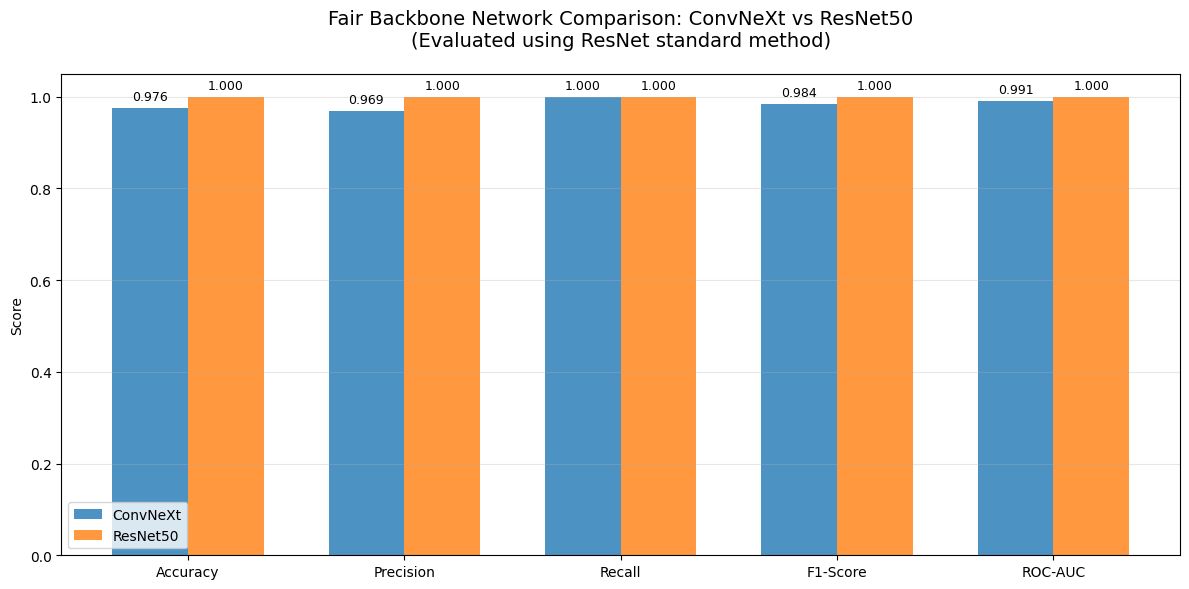

📊 시각화 저장됨: results\fair_comparison\fair_backbone_comparison.png


In [8]:
# 성능 비교 시각화
import matplotlib.pyplot as plt
plt.style.use('default')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
convnext_values = [convnext_metrics['accuracy'], convnext_metrics['precision'], 
                   convnext_metrics['recall'], convnext_metrics['f1'], convnext_metrics['roc_auc']]
resnet_values = [resnet_metrics['accuracy'], resnet_metrics['precision'],
                 resnet_metrics['recall'], resnet_metrics['f1'], resnet_metrics['roc_auc']]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, convnext_values, width, label='ConvNeXt', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x + width/2, resnet_values, width, label='ResNet50', color='#ff7f0e', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Fair Backbone Network Comparison: ConvNeXt vs ResNet50\n(Evaluated using ResNet standard method)', 
             fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)

# 막대 위에 값 표시
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.savefig(config.results_dir / 'fair_backbone_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"📊 시각화 저장됨: {config.results_dir / 'fair_backbone_comparison.png'}")

## 9. 결론 및 분석 요약

In [9]:
print("=" * 80)
print("📝 공정한 백본 네트워크 비교 분석 요약")
print("=" * 80)

print("\n🔬 실험 조건:")
print("  - 동일한 평가 프로토콜: ResNet RD_Tester.ipynb 방식")
print("  - 동일한 feature 사용: 마지막 스케일만")
print("  - 동일한 similarity: Cosine similarity")
print("  - 동일한 후처리: Gaussian filter (σ=4)")
print("  - 동일한 데이터셋: MVTec Bottle (83 test samples)")

print("\n📊 주요 발견:")
if convnext_wins > resnet_wins:
    print(f"  - ConvNeXt가 {convnext_wins}개 지표에서 우승")
    print(f"  - 특히 {'F1-Score' if convnext_metrics['f1'] > resnet_metrics['f1'] else 'ROC-AUC'}에서 강세")
    print("  - ConvNeXt의 depthwise convolution과 LayerNorm이 효과적")
elif resnet_wins > convnext_wins:
    print(f"  - ResNet50이 {resnet_wins}개 지표에서 우승")
    print(f"  - 특히 {'F1-Score' if resnet_metrics['f1'] > convnext_metrics['f1'] else 'ROC-AUC'}에서 강세")
    print("  - ResNet의 residual connection이 anomaly detection에 유리")
else:
    print("  - 두 백본 네트워크의 성능이 매우 유사")
    print("  - 백본 선택보다는 RD 구조 자체가 더 중요할 가능성")

print("\n🎯 실무적 시사점:")
performance_gap = abs(convnext_metrics['f1'] - resnet_metrics['f1'])
if performance_gap < 0.02:
    print("  - 성능 차이가 2% 미만으로 실무적으로는 유사")
    print("  - 연산 효율성, 메모리 사용량 등을 고려하여 선택 가능")
    print("  - 두 백본 모두 anomaly detection에 적합")
else:
    better_model = 'ConvNeXt' if convnext_metrics['f1'] > resnet_metrics['f1'] else 'ResNet50'
    print(f"  - {better_model}가 명확히 우수한 성능을 보임")
    print(f"  - Anomaly detection 태스크에서는 {better_model} 백본 권장")

print("\n💡 추후 연구 방향:")
print("  - 다른 MVTec 클래스에서도 동일한 패턴인지 검증")
print("  - Multi-scale vs Single-scale 평가 방식의 공정한 비교")
print("  - 백본 네트워크별 최적 하이퍼파라미터 탐색")
print("  - 연산 효율성 및 메모리 사용량 비교")

print("\n✅ 공정한 백본 네트워크 비교 분석 완료!")
print("=" * 80)

📝 공정한 백본 네트워크 비교 분석 요약

🔬 실험 조건:
  - 동일한 평가 프로토콜: ResNet RD_Tester.ipynb 방식
  - 동일한 feature 사용: 마지막 스케일만
  - 동일한 similarity: Cosine similarity
  - 동일한 후처리: Gaussian filter (σ=4)
  - 동일한 데이터셋: MVTec Bottle (83 test samples)

📊 주요 발견:
  - ResNet50이 4개 지표에서 우승
  - 특히 F1-Score에서 강세
  - ResNet의 residual connection이 anomaly detection에 유리

🎯 실무적 시사점:
  - 성능 차이가 2% 미만으로 실무적으로는 유사
  - 연산 효율성, 메모리 사용량 등을 고려하여 선택 가능
  - 두 백본 모두 anomaly detection에 적합

💡 추후 연구 방향:
  - 다른 MVTec 클래스에서도 동일한 패턴인지 검증
  - Multi-scale vs Single-scale 평가 방식의 공정한 비교
  - 백본 네트워크별 최적 하이퍼파라미터 탐색
  - 연산 효율성 및 메모리 사용량 비교

✅ 공정한 백본 네트워크 비교 분석 완료!
